# 고양이 분류기

In [0]:
# Set file path if you're not in google colab
pretrained_model_path = "efficientnet-b2_imagenet_1000_notop.h5"
dataset_path = "dataset.npy"

In [0]:
!pip install selenium mechanicalsoup opencv-python beautifulsoup4 efficientnet
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,830 kB]
Get:15 http://ppa.launchpad.net/mar

## 1. 구글에서 이미지 가져오기

### 이미지 크롤러 프로토타입
별로 성능이 좋지 못해서 이건 이용을 하지 않게 됨

In [0]:
import mechanicalsoup
import requests
import pathlib
 
def download_images(path, page):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    img_urls = [i['src'] for i in page.soup.select('div > img')]
    for i, img_url in enumerate(img_urls):
        response = requests.get(img_url)
        with open(path + '/' + f"{i}.png", "wb") as imgfile:
            imgfile.write(response.content)
 
def google_image_search(path, keywords):
    browser = mechanicalsoup.StatefulBrowser(soup_config={'features': 'lxml'})
    
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    url = "https://www.google.com/search?tbm=isch&tbs=ic:color,itp:photo&q="
    pages = []
    for keyword in keywords:
        page = browser.open(url + keyword)
        download_images(path + '/' + keyword, page)

### 이미지 크롤러 완성 버전
> 1. 스크롤이 된다. 무한스크롤에 대처 가능
> 2. 이미지 타입이 이상해도 디코딩해서 다운하게 했다.
> 3. 다중 키워드 지원
> 4. 검색어 끝나면 끝났다고 말해줌


In [0]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import ElementNotInteractableException
from bs4 import BeautifulSoup
import urllib3
import time
from collections import defaultdict
from base64 import b64decode
import pathlib
 
def scroll_until_end(browser):
    last_height = browser.execute_script("return document.body.scrollHeight")
    
    while True:
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
 
        # Wait to load page
        time.sleep(0.8)
 
        # Calculate new scroll height and compare with last scroll height
        new_height = browser.execute_script("return document.body.scrollHeight")
 
        if new_height == last_height:
            break
 
        last_height = new_height
 
def save_images(path, img_dict):
    
    if not img_dict:
        return False
    
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    
    count = 0
    for k, v in img_dict.items():
        for data in v:
            try:
                if k == 'url':
                    #res = requests.get(url, verify=False, stream=True)
                    img = requests.get(data, verify=False, stream=True).raw.read()
                    #rawdata = res.raw.read()
                else:
                    header, encoded = data.split(",", 1)
                    img = b64decode(encoded)
                    
                with open(pathlib.Path(path, str(count) + '.jpg'), 'wb') as f:
                    f.write(img)
                
                count += 1   
 
            except Exception as e:
                print('Failed to write image.')
                print(e)
                
    return count
 
def process_tags(img_tags):
    img_dict = defaultdict(list)
        
    for image in img_tags:
        if image.has_attr('src'):
            url = image['src']
        elif image.has_attr('data-src'):
            url = image['data-src']
        else:
            print('Can not save image')
            continue
            
        if not url.find('https://'):
            img_dict['url'].append(url)
        else:
            img_dict['data'].append(url)
 
    return img_dict
 
def get_image_tags(browser, keyword, numofimages, emphasize=''):
    base = 'https://www.google.com/search?source=lnms&tbm=isch&tbs=itp:photo&q='
    browser.get(base + keyword + ' ' + emphasize)
    
    languages = {'ko': '결과 더보기', 'ja': '結果をもっと表示', 'en': 'show more result'}
    lang = browser.execute_script("return window.navigator.userLanguage || window.navigator.language")[:2]
 
    time.sleep(1)
 
    while True:
        scroll_until_end(browser)
        print('Reached the end of the page.')
        time.sleep(0.8)
        print('Retrieving...')
        time.sleep(0.8)
 
        page_source = browser.page_source 
 
        soup = BeautifulSoup(page_source, 'lxml')
        images = soup.select('div > img')
 
        if len(images) >= numofimages:
            images = images[:numofimages]
            print("Image count exceeded")
            break
 
        try:
            browser.find_element_by_xpath(f'//input[@value="{languages[lang]}"]').click()
        except ElementNotInteractableException:
            print("No more results")
            break
            
    return images
 
        
def download_google_images(path, keywords, numofimages, chromedriver='chromedriver.exe', **kwargs):
    emphasize = '';
    if 'emphasize' in kwargs:
        emphasize = kwargs['emphasize']
    
    urllib3.disable_warnings()
    
    
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    #options.add_argument('--headless')
 
    try:
        browser = webdriver.Chrome(chromedriver, options=options)
    except Exception as e:
        print(f'No found chromedriver in this environment.')
        print(f'Install on your machine. exception: {e}')
        return
    
    
    browser.set_window_size(1280, 1024)
    #print('Getting you a lot of images. This may take a few moments...')
    
    if type(keywords) == str:
        keywords = [keywords]
    
    all_counts = 0
    for keyword in keywords:
        dst = pathlib.Path(path, keyword)
        
        tags = get_image_tags(browser, keyword, numofimages, emphasize=emphasize)
        img_dict = process_tags(tags)
        
        img_count = save_images(dst, img_dict)
        print(f'Saved {img_count} images of label {keyword}')
        all_counts += img_count
        
                    
    browser.close()
    
    return all_counts

### 이미지 다운해보기
이미지 다운에는 시간이 오래걸리기에 머신러닝 모델에 필요한 키워드만 남긴채 주석처리

In [0]:
labels = ["norwegian forest", "russian blue", "ragdoll", "maine coon", "bengal"]

In [0]:
#download_google_images('cats', labels, 5000, '/usr/lib/chromium-browser/chromedriver', emphasize='cat')

## 다운받은 이미지를 전처리

> 1. <s>OpenCV 캐스케이딩을 활용해서 고양이가 검출되지 않으면 그 이미지는 삭제하는 식으로 하자!</s> > 실험 결과가 좋지 않아서 실패
> 2. 이미지 사이즈를 일정하게 맞춤 -> 128px x 128px
> 3. 이미지 값을 0 ~ 1 사이로 정규화하려 했으나 그것은 나중에 처리하려고 함


#### 캐스케이드 파일 모음 링크 
https://github.com/opencv/opencv/tree/master/data/haarcascades

https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface_extended.xml

In [0]:
cascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface_extended.xml"
xml_content = requests.get(cascade_url).content
 
cascade_file = cascade_url.split('/')[-1]
 
with open(cascade_file, 'wb') as xmlfile:
    xmlfile.write(xml_content)

In [0]:
import cv2
 
cat_ext_cascade = cv2.CascadeClassifier(cascade_file)
 
SF = 1.03
N = 3

In [0]:
import numpy as np
import shutil
 
def process_images(path, size, cascade=None):
    wordkspace = path + '_resized'
    pathlib.Path(wordkspace).mkdir(parents=True, exist_ok=True)
    
    path = pathlib.Path(path)
    
    subdirs = [x for x in path.iterdir() if x.is_dir()]
 
    for subdir in subdirs:
        pathlib.Path(wordkspace, subdir.name).mkdir(parents=True, exist_ok=True)
        files = [x for x in subdir.iterdir() if x.is_file()]
        
        for file in files:
            src = subdir / file.name
            dst = wordkspace / pathlib.Path('/'.join(src.parts[1:]))
            
            img = cv2.imread(str(src))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            if cascade:
                detected = cascade.detectMultiScale(gray, scaleFactor=SF, minNeighbors=N)
 
                if np.array(detected).any():
                    continue
                
            img = cv2.resize(img, (size,size))
            cv2.imwrite(str(dst), img)

In [0]:
#process_images('cats', 128)

### 처리된 이미지들을 바탕으로 데이터셋 만들기
Label들을 컴퓨터가 인식할 수 있는 수로 바꿔주고 (ex. Russan Blue -> 2)    
데이터와 Label을 각각 묶기

In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
 
encoder = LabelEncoder()
encoder.fit(labels)
 
def make_dataset(path):
    
    images = []
    labels = []
    
    
    path = pathlib.Path(path)
    
    subdirs = [x for x in path.iterdir() if x.is_dir()]
 
    for subdir in subdirs:
        files = [x for x in subdir.iterdir() if x.is_file()]
        
        for file in files:
            src = subdir / file.name
            
            img = cv2.imread(str(src), cv2.IMREAD_COLOR)

            images.append(list(img))
            labels.append(subdir.name)

    labels = encoder.transform(np.array(labels).reshape(-1, 1))
    s = np.arange(len(images))
    np.random.shuffle(s)
 
    x = np.array(images)[s]
    labels = np.array(labels)[s]
    y = np.array([labels])
    
    np.save('dataset.npy', (x, y))
    
    return (images, (x, y))

In [0]:
#make_dataset('cats_resized')

### 데이터셋을 로드하는 함수 만들기
만들어진 데이터를 로드해서 시간을 절약하기 위함

In [0]:
def load_dataset(path):
    x, y = np.load(path, allow_pickle=True)
    return x, y[0]

In [0]:
x, y = load_dataset(dataset_path)

### Train set, Test set 나누기
여기서 데이터를 정규화(Normalize) 했음.

In [0]:
train_size = 0.7

s = int(len(x) * train_size)
x = x / 255.0
x_train = x[:s]
x_test = x[s:]

y_train = y[:s]
y_test = y[s:]

## 분류기 모델 선언
기존 efficientnet이라는 이미지 분류 모델을 사용하였으며 거기에 global pooling 적용 (관련 논문에서 효과적이라고 해서 실험적으로 넣어봄)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from time import time
import efficientnet.tfkeras as efn 
from tensorflow import keras
import cv2

class EFNet():
    def __init__(self, output_size, batch_size, ef_nm, img_shape, sample_size):
        self.output_size = output_size
        self.batch_size = batch_size
        self.ef_nm = ef_nm
        self.weight_path = "/content/drive/My Drive/weight/"+ self.ef_nm + ".h5"
        #self.log_path = self.ef_nm + ".csv" #"log/" + self.ef_nm + ".csv"
        self.img_shape = img_shape
        self.sample_size = sample_size
   
        effnet = self.getEFNet()
        self.model = self.buildModel(effnet)
        


    def getEFNet(self):
        effnet = efn.EfficientNetB2(weights=None,\
                                include_top=False,\
                                input_shape=self.img_shape)
        
        effnet.load_weights(pretrained_model_path)

        for i, layer in enumerate(effnet.layers):
            if "batch_normalization" in layer.name:
                effnet.layers[i] = GroupNormalization(groups=self.batch_size, axis=-1, epsilon=0.0001)

        return effnet


    def buildModel(self, effnet):
        model = Sequential()

        model.add(effnet)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(self.output_size, activation='softmax')) 

        model.compile(loss="sparse_categorical_crossentropy",\
                            optimizer=Adam(lr=0.00005),\
                            metrics=['accuracy', 'binary_crossentropy'])
        
        return model
    
    def fit(self, train_x, train_y, test_x, test_y):
        es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
        checkpoint = ModelCheckpoint(self.weight_path, \
                                    monitor='val_accuracy', \
                                    verbose=1, \
                                    save_best_only=True, \
                                    save_weights_only=True, \
                                    mode='max')
        
        hist = self.model.fit(train_x, \
                        train_y, \
                        batch_size=self.batch_size, \
                        epochs=20, \
                        validation_data=(test_x, test_y), \
                        verbose=1, \
                        callbacks=[es, checkpoint])

        return hist

    def fitGenerator(self, train_generator, val_generator, train_len, val_len):
        es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
        
        weight_nm = "weight\\" + self.ef_nm + "-{epoch:02d}-{val_accuracy:.4f}.h5"
        checkpoint = ModelCheckpoint(weight_nm, \
                                     monitor='val_accuracy', \
                                     verbose=1, \
                                     save_best_only=True, \
                                     save_weights_only=True, \
                                     mode='max')
        
        #pathlib.Path(self.log_path).mkdir(parents=True, exist_ok=True)
        
        #csvlogger = CSVLogger(self.log_path, append=True, separator=',')
        
        tensorboard_path = 'tensorboard\\' + self.ef_nm + '\\'
        
        
            
        tensorboard = TensorBoard(log_dir=tensorboard_path+f'{time()}')
        
        pathlib.Path(tensorboard_path, 'train').mkdir(parents=True, exist_ok=True)
        
        self.model.fit(train_generator, \
                                validation_data=val_generator, \
                                validation_steps=(val_len * self.sample_size) // self.batch_size, \
                                steps_per_epoch=(train_len * self.sample_size) // self.batch_size, \
                                epochs=50, \
                                callbacks=[es, checkpoint, tensorboard])#csvlogger,tensorboard])
        self.save()


    def save(self):
        self.model.save_weights(self.weight_path)
        print("success save model weights")

    def load(self):
        self.model.load_weights(self.weight_path)
        print("success load model weights")

    def predict(self, test_x):
        return self.model.predict(test_x)

    def predictGenerator(self, predict_generator, img_len):
        return self.model.predict_generator(predict_generator, steps=img_len//self.batch_size)

### 부수적인 것: Data Augmentation
데이터를 이리 비틀고 저리 비틀어서 적은 데이터에도 효과적인 학습을 이루려 했으나 메모리 문제로 사용하지 않음

In [0]:
class Preprocess():
    def __init__(self, batch_size, img_size):
        self.img_size = img_size
        self.batch_size = batch_size

    def makeGenerator(self, train_x, train_y):
        fit_val = dict(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.2, 1.), 
                 zoom_range=0.2, horizontal_flip=False, vertical_flip=False)
        
        datagen = ImageDataGenerator(rotation_range     = fit_val['rotation_range'],\
                                   horizontal_flip            = fit_val['horizontal_flip'],\
                                   vertical_flip              = fit_val['vertical_flip'],\
                                   preprocessing_function     = self.GeneratePreprocess, \
                                   rescale                     = 1 / 255.,\
                                   fill_mode                  = "constant", \
                                   cval                       = 0,\
                                   width_shift_range          = fit_val['width_shift_range'], \
                                   height_shift_range         = fit_val['height_shift_range'], \
                                   zoom_range                 = fit_val['zoom_range'],\
                                   brightness_range           = fit_val['brightness_range'])
        datagen.fit(x_train)
        train_generator = datagen.flow(train_x, train_y, batch_size=self.batch_size)
        
        return train_generator

    def makePredictGenerator(self, predict_x):
        datagen = ImageDataGenerator(rescale = 1/ 255.)
        predict_generator = datagen.flow(predict_x, batch_size=self.batch_size, shuffle=False)
        return predict_generator

    def GeneratePreprocess(self, img):
        img = cv2.resize(img, (self.img_size, self.img_size))
        return img

## 모델 학습시키기

In [0]:
model = EFNet(output_size=5, batch_size=128, ef_nm='1', img_shape=(128, 128, 3), sample_size=0.3)

In [0]:
#Preprocessor = Preprocess(batch_size=128, img_size=128)
#train = Preprocessor.makeGenerator(x_train, y_train)
#test = Preprocessor.makeGenerator(x_test, y_test)

In [0]:
hist = model.fit(x_train, y_train, x_test, y_test)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5840 - accuracy: 0.2889 - binary_crossentropy: 3.2396 
Epoch 00001: val_accuracy improved from -inf to 0.32745, saving model to /content/drive/My Drive/weight/1.h5
17/17 [==============================] - 284s 17s/step - loss: 1.5840 - accuracy: 0.2889 - binary_crossentropy: 3.2396 - val_loss: 1.5166 - val_accuracy: 0.3275 - val_binary_crossentropy: 3.2129
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.3002 - accuracy: 0.4941 - binary_crossentropy: 3.3364 
Epoch 00002: val_accuracy improved from 0.32745 to 0.42668, saving model to /content/drive/My Drive/weight/1.h5
17/17 [==============================] - 280s 16s/step - loss: 1.3002 - accuracy: 0.4941 - binary_crossentropy: 3.3364 - val_loss: 1.3844 - val_accuracy: 0.4267 - val_binary_crossentropy: 3.3392
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.6232 - binary_crossentropy: 3.5260 
Epoch 00003: v

### 학습 과정 그래프
시간이 지날수록 Accuracy(정확도)가 증가하고, Loss(오차율)이 줄어듦을 알 수 있음

In [0]:
import matplotlib.pyplot as plt

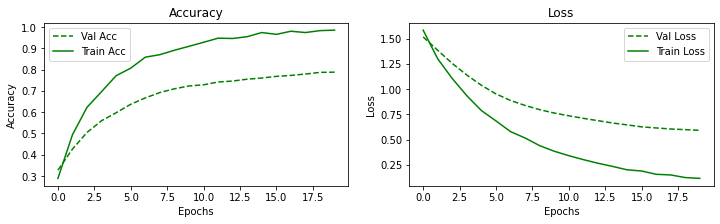

In [0]:
fig = plt.figure(figsize=(12, 3))

ax = plt.subplot(1, 2, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
 
ax.plot(hist.history['val_accuracy'], label='Val Acc', color='g', linestyle='--')
ax.plot(hist.history['accuracy'], label='Train Acc', color='g')
plt.legend()

ax = plt.subplot(1, 2, 2)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
 
ax.plot(hist.history['val_loss'], label='Val Loss', color='g', linestyle='--')
ax.plot(hist.history['loss'], label='Train Loss', color='g')
plt.legend()

## 테스트 하는 함수
모델 예측을 하고 이 예측값을 사람이 볼 수 있는 걸로 쉽게 변환해줌.    
모델이랑 인코더, 이미지 링크만 있으면 자동으로 다운한다.

지원되는 고양이 레이블: "norwegian forest", "russian blue", "ragdoll", "maine coon", "bengal"

In [0]:
korean_table = {'norwegian forest': '노르웨이 숲', 'russian blue': '러시안 블루', 'ragdoll': '레그돌', 'maine coon': '메인쿤', 'bengal': '벵갈고양이'}

In [0]:
import requests
import cv2
import matplotlib.pyplot as plt

def predict_image(model, encoder, imglink):
  resp = requests.get(imglink, stream=True)
  with open('test.jpg', 'wb') as f:
    f.write(resp.content)
  
  img = cv2.imread('test.jpg')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  img = cv2.resize(img, (128, 128))
  img = img / 255.0
  p = model.predict(img.reshape(-1, 128, 128, 3))
  idx = np.argmax(p)
  [res] = encoder.inverse_transform([idx])
  txt = '\n'.join([f"{korean_table[encoder.inverse_transform([i])[0]]}: {probability*100:.2f}%" for i, probability in enumerate(p[0])])
  print(txt)
  return korean_table[res]

벵갈고양이: 0.12%
메인쿤: 19.98%
노르웨이 숲: 78.75%
레그돌: 1.09%
러시안 블루: 0.05%


'노르웨이 숲'

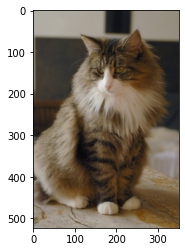

In [0]:
url = 'https://t1.daumcdn.net/cfile/tistory/998B6B33599A5F7420'
predict_image(model, encoder, url)

벵갈고양이: 0.52%
메인쿤: 0.10%
노르웨이 숲: 0.09%
레그돌: 0.16%
러시안 블루: 99.13%


'러시안 블루'

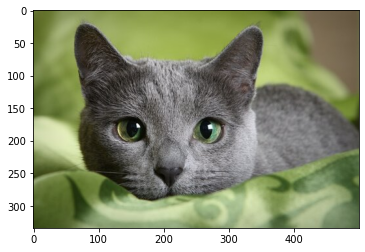

In [0]:
url = 'https://myanimals.co.kr/wp-content/uploads/2018/09/russian-blue-cat.jpg'
predict_image(model, encoder, url)

벵갈고양이: 94.72%
메인쿤: 3.57%
노르웨이 숲: 0.25%
레그돌: 0.17%
러시안 블루: 1.29%


'벵갈고양이'

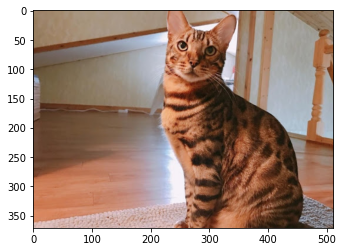

In [0]:
url = 'https://lh3.googleusercontent.com/proxy/ot2v6C01XQYoX0Gaixu62TLzazR4b-v4XOh7Rnzti8qpB2Vx8Nhkb0D02V425QTHJYahqyCTkRHdqjXed-Qx1gbwi_AZPRWNRKtW6D816Fu-qNcme3y3GHJU3dgt8bjeIhd-2D8EXVJ2SdWTmQ5S_wmuwOyMv4KzZu6UJrTfnb4_VGsKwl0'
predict_image(model, encoder, url)

벵갈고양이: 2.14%
메인쿤: 23.41%
노르웨이 숲: 40.54%
레그돌: 32.92%
러시안 블루: 1.00%


'노르웨이 숲'

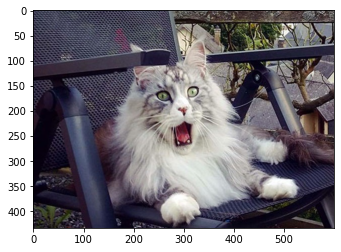

In [0]:
# 비슷해서 기계도 헷갈리는 거 같음 / 원래는 메인쿤
url = 'https://img1.daumcdn.net/thumb/S600x434/?scode=1boon&fname=https://t1.daumcdn.net/liveboard/petzzi/f6f4bb8c4451495f867edea92e9c36e4.JPG'
predict_image(model, encoder, url)

벵갈고양이: 21.89%
메인쿤: 57.22%
노르웨이 숲: 13.86%
레그돌: 2.58%
러시안 블루: 4.45%


'메인쿤'

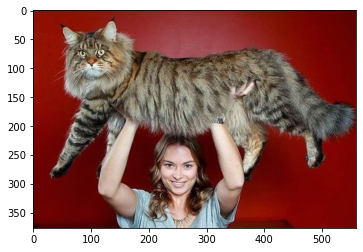

In [0]:
url = 'https://image.news1.kr/system/ap/2015/11/26/1658301/dims/optimize'
predict_image(model, encoder, url)

벵갈고양이: 0.02%
메인쿤: 0.07%
노르웨이 숲: 0.06%
레그돌: 99.70%
러시안 블루: 0.15%


'레그돌'

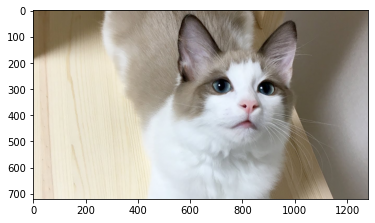

In [0]:
url = 'https://i.ytimg.com/vi/N0t6iwRjsIg/maxresdefault.jpg'
predict_image(model, encoder, url)